## Generator 可以使用 next 來進行循環中的一步

In [0]:
def output_from_list_generator(your_list):
    for i in your_list:
        yield i 

In [0]:
my_list = [1, 2, 3, 4, 5]
gen = output_from_list_generator(my_list)

for n in range(len(my_list)+1):
    print(next(gen))

1
2
3
4
5


StopIteration: ignored

### 從上面的範例程式碼我們可以看到，當使用一次 next，generator 就會跑 for_loop 一次，因此得到 list 中的第一個值，當再使用一次後，for_loop 記得上次的循環，所以吐出第二個值。最後一次，因為 for loop 已經執行結束了，所以再使用 next 就會看到 StopIteration，無法再得到值。

### 我們可以撰寫一個無限循環的 Generator，只要使用 While True 即可，只要 call next 就一定會跑一次循環，並返回值

In [0]:
def inf_loop_generator(your_list):
    while True:
        for i in your_list:
            yield i

In [2]:
my_list = [1, 2, 3, 4, 5]
gen = inf_loop_generator(my_list)

for n in range(len(my_list)+1):
    print(next(gen))

1
2
3
4
5
1


## 雖然 Cifar-10 的資料可以全部讀進記憶體，但讓我們試著用 Generator，批次的把 Cifar 10 的資料取出來，一次取 32 張出來！

In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step
Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000, 1)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)


In [0]:
def cifar_generator(images, labels, batch_size=32):
    while True:
        for i in range(0, len(images), batch_size):
            images_gen = images[i: i + batch_size]
            labels_gen = labels[i: i + batch_size]
            yield images_gen, labels_gen

In [0]:
# 針對物件圖像數據集的類別編列成字典
label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
label_dict = dict(zip(range(0, len(label_list)), label_list))


# 宣告一個影像標記的函數
def plot_images_labels(images, labels, idx, num):
    import matplotlib.pyplot as plt
    import math

    # 創造 rows x cols 的子圖
    cols = 8
    rows = math.ceil(num / cols)
    figure, ax = plt.subplots(rows, cols, figsize=(16,8))

    for i in range(0, num):
        # 鎖定子圖位置
        plt.subplot(rows, cols, 1+i)

        # 顯示 images 內第幾張圖片
        plt.imshow(images[idx])

        # 顯示 images 內第幾張圖片的標題        
        title = f"{i+1}.{label_dict[labels[idx][0]]}"
        idx += 1 

        # 一些畫圖設定  
        plt.title(title, fontsize=15) 
        plt.xticks([]); plt.yticks([])

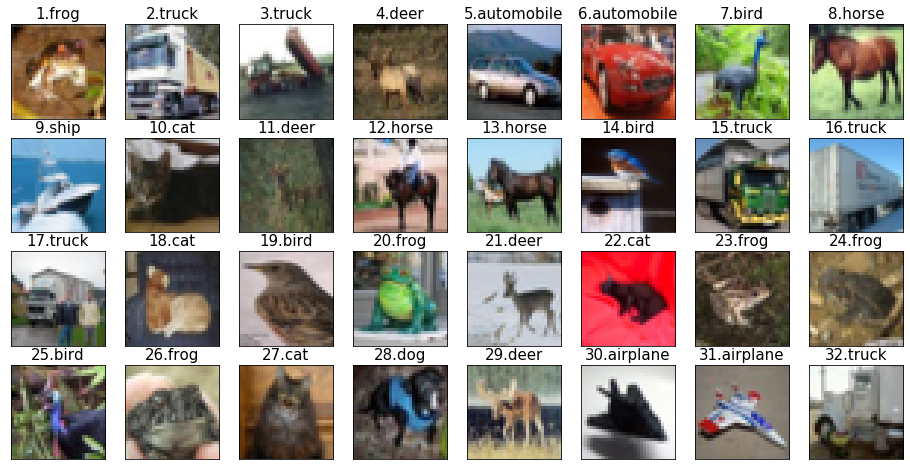

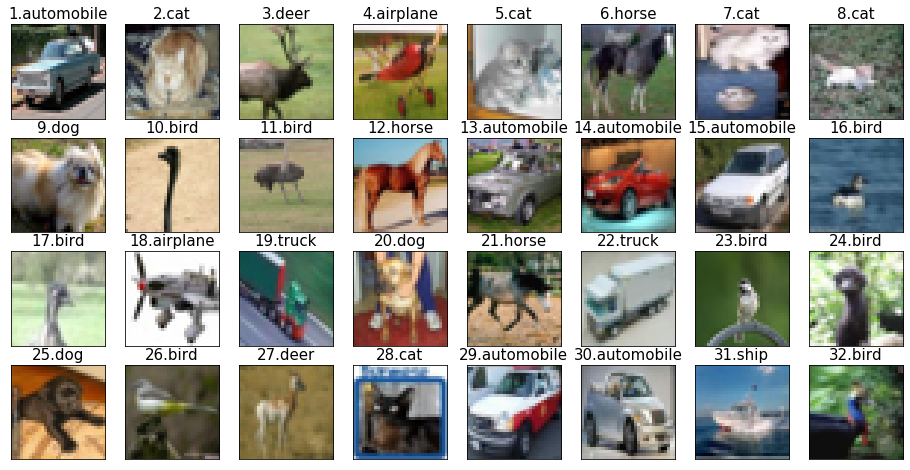

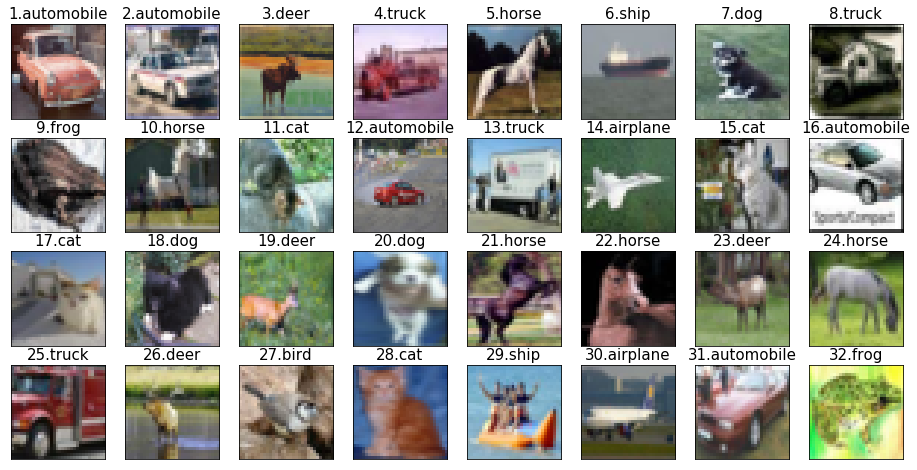

In [6]:
batch_size_4_gen = 32
cifar_gen = cifar_generator(x_train, y_train, batch_size=batch_size_4_gen)
for i in range(3):
    x_train_gen, y_train_gen = next(cifar_gen)
    plot_images_labels(x_train_gen, y_train_gen, idx=0, num=batch_size_4_gen)

## 作業

請參考昨天的程式碼，將訓練資料讀取方式改寫成 Generator，並將原本的 model.fit 改為 model.fit_generator 來進行訓練。請參考 Keras [官方文件中 fit_generator 的說明](https://keras.io/models/sequential/)

In [0]:
import keras
import keras.backend as K
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.datasets import cifar10
from keras import regularizers
from keras import optimizers
from keras.callbacks import LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt

In [0]:
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量
weight_decay = 1e-4

In [9]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f"x_train shape: {x_train.shape}, {x_train.shape[0]} train samples")
print(f"x_test shape: {x_test.shape}, {x_test.shape[0]} test samples")

# 將資料標準化
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3), 50000 train samples
x_test shape: (10000, 32, 32, 3), 10000 test samples


In [10]:
batch_size_4_gen = 512
train_gen = cifar_generator(x_train, y_train, batch_size=batch_size_4_gen)
test_gen = cifar_generator(x_test, y_test, batch_size=batch_size_4_gen)

for x_train_gen, y_train_gen in train_gen:
    print('data batch shape:', x_train_gen.shape)
    print('labels batch shape:', y_train_gen.shape)
    break

data batch shape: (512, 32, 32, 3)
labels batch shape: (512, 10)


In [0]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 35:
        lrate = 0.0005
    if epoch > 50:
        lrate = 0.0003
    return lrate

In [13]:
K.clear_session()

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

# Fitting the model using a batch generator
history = model.fit_generator(train_gen,
                              steps_per_epoch=int(np.ceil(x_train.shape[0]/batch_size_4_gen)),
                              epochs=75,
                              validation_data=test_gen,
                              validation_steps=int(np.ceil(x_test.shape[0]/batch_size_4_gen)),
                              callbacks=[LearningRateScheduler(lr_schedule)])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/75
98/98 [==============================] - 12s 125ms/step - loss: 3.5444 - acc: 0.3141 - val_loss: 1.8518 - val_acc: 0.3914
Epoch 2/75
98/98 [==============================] - 4s 46ms/step - loss: 1.5050 - acc: 0.4952 - val_loss: 1.6345 - val_acc: 0.5086
Epoch 3/75
98/98 [==============================] - 4s 45ms/step - loss: 1.1789 - acc: 0.6023 - val_loss: 1.0471 - val_acc: 0.6581
Epoch 4/75
98/98 [==============================] - 4s 45ms/step - loss: 0.9599 - acc: 0.6771 - val_loss: 1.0319 - val_acc: 0.6734
Epoch 5/75
98/98 [==============================] - 4s 45ms/step - loss: 0.8319 - acc: 0.7269 - val_loss: 0.9129 - val_acc: 0.7073
Epoch 6/75
98/98 [==============================] - 4s 45ms/step - loss: 0.7286 - acc: 0.7633 - val_loss: 0.9024 - val_acc: 0.7221
Epoch 7/75
98/98 [==============================] - 4s 45ms/step - loss: 0.6492 - acc: 0.7901 - val_loss: 0.8115 -

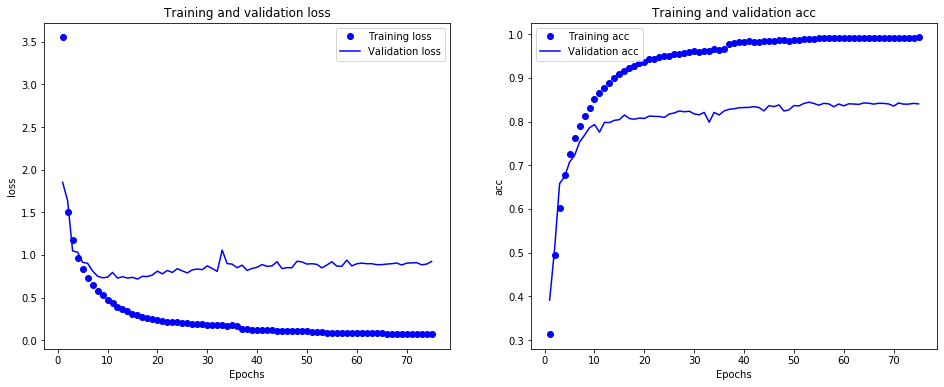

In [16]:
# Displaying curves of loss and accuracy during training
epochs = range(1, len(history.history['loss']) + 1)

rows, cols = 1, 2
figure, ax = plt.subplots(rows, cols, figsize=(16,6))

for i, metric in enumerate(['loss', 'acc']):
    plt.subplot(1, 2, i+1)
    plt.plot(epochs, history.history[metric], 'bo', label=f"Training {metric}")
    plt.plot(epochs, history.history['val_'+metric], 'b', label=f"Validation {metric}")
    plt.title(f"Training and validation {metric}")
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()